<a href="https://colab.research.google.com/github/kaleem500bc/Vanilla-policy-gradient/blob/main/Vanilla_policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyVirtualDisplay

In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import gym
from torch.distributions.categorical import Categorical
from IPython.display import clear_output
from IPython import display
from pyvirtualdisplay import Display
import os
from matplotlib import pyplot as plt

In [4]:
# make virtual screen and redirect render to this screen
# From https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!bash ../xvfb start
os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 144786 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.7_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.7) ...
Setting up xvfb (2:1.19.6-1ubuntu4.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [5]:
class model(nn.Module):
  def __init__(self, n_states,n_actions):
    super().__init__()
    self.fc1 = nn.Linear(n_states,128)
    self.fc2 = nn.Linear(128,256)
    self.fc = nn.Linear(256,n_actions)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc(x)
    return x

class Agent(object):
  def __init__(self, n_actions, n_states):
    self.loss = []
    self.score = []
    self.rewardHistory = []
    self.actionsHistory = []
    self.statesHistory = []
    self.model = model(n_actions, n_states)
    self.optimizer = torch.optim.Adam(self.model.parameters(),
                                      lr = 0.0001)

  def getActionDistribution(self, state):
    # Use categorical/ multinomial distribution for discrete action space
    # as it allows exploration instead of argmax
    # Use logits as the output of the model might not sum up to 1
    act = Categorical(logits = self.model(state))
    return act
  
  def getAction(self,state):
    # Get action from the model given 'state' and sample from the multinomial 
    # distribution 
    act = self.getActionDistribution(state).sample().item()
    return act


  def train(self,episode):
    state = env.reset()
    done = False

    # Run agent for one full episode
    while not done:
      self.statesHistory.append(state)
      act = self.getAction(torch.as_tensor(state,dtype=torch.float))
      state, reward, done, _ = env.step(act)
      self.rewardHistory.append(reward)
      self.actionsHistory.append(act)
    
    # Get loss for the episode
    loss = self.lossFunc()


    # Back Propagation for 1 episode (Can be easily expanded to 
    # multiple episode which is more efficient)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.loss.append(loss)
    self.score.append(len(self.rewardHistory))
    print("episode: {}, Loss: {}, score: {}".format(episode,loss,
                                                    len(self.rewardHistory)))

    # Reset variables for the next episode
    self.statesHistory = []
    self.actionsHistory = []
    self.rewardHistory = []
    
  # Calculate loss for 1 episode
  def lossFunc(self):

    rewards_of_trajectory = sum(self.rewardHistory)
    reward_tau = torch.as_tensor(len(self.rewardHistory)*rewards_of_trajectory,
                                            dtype=torch.float)
    
    # Get log probablities from the distribution
    # refer to the loss function of policy gradient
    actionsProbs = self.getActionDistribution(
        torch.as_tensor(self.statesHistory, dtype=torch.float)).log_prob(
            torch.as_tensor(self.actionsHistory,dtype=torch.float))

    # Negative sign for gradient ascend as BBP in torch is gradient descend
    loss = -(reward_tau * actionsProbs).mean()
    return loss


In [6]:
env = gym.make("CartPole-v0")
agent = Agent(env.observation_space.shape[0],env.action_space.n)


In [7]:
episode = 1000
for e in range(episode):
  agent.train(e)

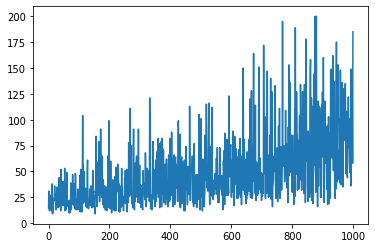

In [8]:
plt.plot(agent.score, label="Score")

In [10]:
# Testing the agent
state = env.reset()
done = False
display_img = plt.imshow(env.render("rgb_array"))
i = 0
while not done:
  state = torch.tensor(state,dtype=torch.float)
  action = agent.model(state)
  action = int(torch.argmax(action).item())
  state, reward, done, _ = env.step(action)
  display_img.set_data(env.render("rgb_array"))
  clear_output(wait=True)
  display.display(plt.gcf())
  i += 1
print("Score: ",i)

Score:  105
